**Important: This notebook will only work with fastai-0.7.x. Do not try to run any fastai-1.x code from this path in the repository because it will load fastai-0.7.x**

> This is my revised and extended version of the first notebook from the [Fast.ai ML course (2018)](http://course18.fast.ai/ml). It covers lessons 1 and 2.

# Intro to Random Forests

## About this course

### Teaching approach

This course is being taught by Jeremy Howard, and was developed by Jeremy along with Rachel Thomas. Rachel has been dealing with a life-threatening illness so will not be teaching as originally planned this year.

Jeremy has worked in a number of different areas - feel free to ask about anything that he might be able to help you with at any time, even if not directly related to the current topic:

- Management consultant (McKinsey; AT Kearney)
- Self-funded startup entrepreneur (Fastmail: first consumer synchronized email; Optimal Decisions: first optimized insurance pricing)
- VC-funded startup entrepreneur: (Kaggle; Enlitic: first deep-learning medical company)

I'll be using a *top-down* teaching method, which is different from how most math courses operate.  Typically, in a *bottom-up* approach, you first learn all the separate components you will be using, and then you gradually build them up into more complex structures.  The problems with this are that students often lose motivation, don't have a sense of the "big picture", and don't know what they'll need.

If you took the fast.ai deep learning course, that is what we used.  You can hear more about my teaching philosophy [in this blog post](http://www.fast.ai/2016/10/08/teaching-philosophy/) or [in this talk](https://vimeo.com/214233053).

Harvard Professor David Perkins has a book, [Making Learning Whole](https://www.amazon.com/Making-Learning-Whole-Principles-Transform/dp/0470633719) in which he uses baseball as an analogy.  We don't require kids to memorize all the rules of baseball and understand all the technical details before we let them play the game.  Rather, they start playing with a just general sense of it, and then gradually learn more rules/details as time goes on.

All that to say, don't worry if you don't understand everything at first!  You're not supposed to.  We will start using some "black boxes" such as random forests that haven't yet been explained in detail, and then we'll dig into the lower level details later.

To start, focus on what things DO, not what they ARE.

### Your practice

People learn by:
1. **doing** (coding and building)
2. **explaining** what they've learned (by writing or helping others)

Therefore, we suggest that you practice these skills on Kaggle by:
1. Entering competitions (*doing*)
2. Creating Kaggle kernels (*explaining*)

It's OK if you don't get good competition ranks or any kernel votes at first - that's totally normal! Just try to keep improving every day, and you'll see the results over time.

To get better at technical writing, study the top ranked Kaggle kernels from past competitions, and read posts from well-regarded technical bloggers. Some good role models include:

- [Peter Norvig](http://nbviewer.jupyter.org/url/norvig.com/ipython/ProbabilityParadox.ipynb) (more [here](http://norvig.com/ipython/))
- [Stephen Merity](https://smerity.com/articles/2017/deepcoder_and_ai_hype.html)
- [Julia Evans](https://codewords.recurse.com/issues/five/why-do-neural-networks-think-a-panda-is-a-vulture) (more [here](https://jvns.ca/blog/2014/08/12/what-happens-if-you-write-a-tcp-stack-in-python/))
- [Julia Ferraioli](http://blog.juliaferraioli.com/2016/02/exploring-world-using-vision-twilio.html)
- [Edwin Chen](http://blog.echen.me/2014/10/07/moving-beyond-ctr-better-recommendations-through-human-evaluation/)
- [Slav Ivanov](https://blog.slavv.com/picking-an-optimizer-for-style-transfer-86e7b8cba84b) (fast.ai student)
- [Brad Kenstler](https://hackernoon.com/non-artistic-style-transfer-or-how-to-draw-kanye-using-captain-picards-face-c4a50256b814) (fast.ai and USF MSAN student)

### Books

The more familiarity you have with numeric programming in Python, the better. If you're looking to improve in this area, we strongly suggest Wes McKinney's [Python for Data Analysis, 2nd ed](https://www.amazon.com/Python-Data-Analysis-Wrangling-IPython/dp/1491957662/ref=asap_bc?ie=UTF8).

For machine learning with Python, we recommend:

- [Introduction to Machine Learning with Python](https://www.amazon.com/Introduction-Machine-Learning-Andreas-Mueller/dp/1449369413): From one of the scikit-learn authors, which is the main library we'll be using
- [Python Machine Learning: Machine Learning and Deep Learning with Python, scikit-learn, and TensorFlow, 2nd Edition](https://www.amazon.com/Python-Machine-Learning-scikit-learn-TensorFlow/dp/1787125939/ref=dp_ob_title_bk): New version of a very successful book. A lot of the new material however covers deep learning in Tensorflow, which isn't relevant to this course
- [Hands-On Machine Learning with Scikit-Learn and TensorFlow](https://www.amazon.com/Hands-Machine-Learning-Scikit-Learn-TensorFlow/dp/1491962291/ref=pd_lpo_sbs_14_t_0?_encoding=UTF8&psc=1&refRID=MBV2QMFH3EZ6B3YBY40K)


### Syllabus in brief

Depending on time and class interests, we'll cover something like (not necessarily in this order):

- Train vs test
  - Effective validation set construction
- Trees and ensembles
  - Creating random forests
  - Interpreting random forests
- What is ML?  Why do we use it?
  - What makes a good ML project?
  - Structured vs unstructured data
  - Examples of failures/mistakes
- Feature engineering
  - Domain specific - dates, URLs, text
  - Embeddings / latent factors
- Regularized models trained with SGD
  - GLMs, Elasticnet, etc (NB: see what James covered)
- Basic neural nets
  - PyTorch
  - Broadcasting, Matrix Multiplication
  - Training loop, backpropagation
- KNN
- CV / bootstrap (Diabetes data set?)
- Ethical considerations

Skip:

- Dimensionality reduction
- Interactions
- Monitoring training
- Collaborative filtering
- Momentum and LR annealing


## Imports

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
from fastai.imports import *     # We are data scientists prototyping models. This is not production code!
from fastai.structured import *  # Importing everything and having everything available is quicker and more useful

from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display

from sklearn import metrics
import torch

import os
os.environ['PATH'] += os.pathsep + r'C:\Users\Yago\.conda\envs\fastai\Library\bin\graphviz'

In [3]:
PATH = "data/bulldozers/"

In [4]:
!ls {PATH}

Train.csv


In [5]:
torch.cuda.is_available()

True

# Introduction to *Blue Book for Bulldozers*

## About...

### ...our teaching

At fast.ai we have a distinctive [teaching philosophy](http://www.fast.ai/2016/10/08/teaching-philosophy/) of ["the whole game"](https://www.amazon.com/Making-Learning-Whole-Principles-Transform/dp/0470633719/ref=sr_1_1?ie=UTF8&qid=1505094653).  This is different from how most traditional math & technical courses are taught, where you have to learn all the individual elements before you can combine them (Harvard professor David Perkins call this *elementitis*), but it is similar to how topics like *driving* and *baseball* are taught.  That is, you can start driving without [knowing how an internal combustion engine works](https://medium.com/towards-data-science/thoughts-after-taking-the-deeplearning-ai-courses-8568f132153), and children begin playing baseball before they learn all the formal rules.

### ...our approach to machine learning

Most machine learning courses will throw at you dozens of different algorithms, with a brief technical description of the math behind them, and maybe a toy example. You're left confused by the enormous range of techniques shown and have little practical understanding of how to apply them.

The good news is that modern machine learning can be distilled down to a couple of key techniques that are of very wide applicability. Recent studies have shown that the vast majority of datasets can be best modeled with just two methods:

- *Ensembles of decision trees* (i.e. Random Forests and Gradient Boosting Machines), mainly for structured data (such as you might find in a database table at most companies)
- *Multi-layered neural networks learnt with SGD* (i.e. shallow and/or deep learning), mainly for unstructured data (such as audio, vision, and natural language)

In this course we'll be doing a deep dive into random forests, and simple models learnt with SGD. You'll be learning about gradient boosting and deep learning in part 2.

### ...this dataset

We will be looking at the Blue Book for Bulldozers Kaggle Competition: "The goal of the contest is to predict the sale price of a particular piece of heavy equiment at auction based on it's usage, equipment type, and configuration.  The data is sourced from auction result postings and includes information on usage and equipment configurations."

This is a very common type of dataset and prediciton problem, and similar to what you may see in your project or workplace.

### ...Kaggle Competitions

Kaggle is an awesome resource for aspiring data scientists or anyone looking to improve their machine learning skills.  There is nothing like being able to get hands-on practice and receiving real-time feedback to help you improve your skills.

Kaggle provides:

1. Interesting data sets
2. Feedback on how you're doing
3. A leader board to see what's good, what's possible, and what's state-of-art.
4. Blog posts by winning contestants share useful tips and techniques.

## The data

### Look at the data

Kaggle provides info about some of the fields of our dataset; on the [Kaggle Data info](https://www.kaggle.com/c/bluebook-for-bulldozers/data) page they say the following:

For this competition, you are predicting the sale price of bulldozers sold at auctions. The data for this competition is split into three parts:

- **Train.csv** is the training set, which contains data through the end of 2011.
- **Valid.csv** is the validation set, which contains data from January 1, 2012 - April 30, 2012. You make predictions on this set throughout the majority of the competition. Your score on this set is used to create the public leaderboard.
- **Test.csv** is the test set, which won't be released until the last week of the competition. It contains data from May 1, 2012 - November 2012. Your score on the test set determines your final rank for the competition.

The key fields are in train.csv are:

- SalesID: the unique identifier of the sale
- MachineID: the unique identifier of a machine.  A machine can be sold multiple times
- saleprice: what the machine sold for at auction (only provided in train.csv) [TARGET]
- saledate: the date of the sale

*Question*

What stands out to you from the above description?  What needs to be true of our training and validation sets?

In [6]:
df_raw = pd.read_csv(f'{PATH}Train.csv', low_memory=False, 
                     parse_dates=["saledate"])  # use this for all columns with dates

In any sort of data science work, it's **important to look at your data**, to make sure you understand the format, how it's stored, what type of values it holds, etc. Even if you've read descriptions about your data, the actual data may not be what you expect.

In [7]:
def display_all(df):
    with pd.option_context("display.max_rows", 100, "display.max_columns", 100): 
        display(df)

In [8]:
display_all(df_raw.tail().T)  # Use transposing when you have so many columns!

,401120,401121,401122,401123,401124
SalesID,6333336,6333337,6333338,6333341,6333342
SalePrice,10500,11000,11500,9000,7750
MachineID,1840702,1830472,1887659,1903570,1926965
ModelID,21439,21439,21439,21435,21435
datasource,149,149,149,149,149
auctioneerID,1,1,1,2,2
YearMade,2005,2005,2005,2005,2005
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN
UsageBand,NaN,NaN,NaN,NaN,NaN
saledate,2011-11-02 00:00:00,2011-11-02 00:00:00,2011-11-02 00:00:00,2011-10-25 00:00:00,2011-10-25 00:00:00


In [9]:
display_all(df_raw.describe(include='all').T)

,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
SalesID,401125,NaN,NaN,NaN,NaN,NaN,1.91971e+06,909021,1.13925e+06,1.41837e+06,1.63942e+06,2.24271e+06,6.33334e+06
SalePrice,401125,NaN,NaN,NaN,NaN,NaN,31099.7,23036.9,4750,14500,24000,40000,142000
MachineID,401125,NaN,NaN,NaN,NaN,NaN,1.2179e+06,440992,0,1.0887e+06,1.27949e+06,1.46807e+06,2.48633e+06
ModelID,401125,NaN,NaN,NaN,NaN,NaN,6889.7,6221.78,28,3259,4604,8724,37198
datasource,401125,NaN,NaN,NaN,NaN,NaN,134.666,8.96224,121,132,132,136,172
auctioneerID,380989,NaN,NaN,NaN,NaN,NaN,6.55604,16.9768,0,1,2,4,99
YearMade,401125,NaN,NaN,NaN,NaN,NaN,1899.16,291.797,1000,1985,1995,2000,2013
MachineHoursCurrentMeter,142765,NaN,NaN,NaN,NaN,NaN,3457.96,27590.3,0,0,0,3025,2.4833e+06
UsageBand,69639,3,Medium,33985,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
saledate,401125,3919,2009-02-16 00:00:00,1932,1989-01-17 00:00:00,2011-12-30 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN


> Some books make EDA at this point, but for Jeremy that is not so important.

It's important to note what metric is being used for a project. Generally, selecting the metric(s) is an important part of the project setup. However, in this case Kaggle tells us what metric to use: RMSLE (root mean squared log error) between the actual and predicted auction prices. 

> $RMSE=\sum([Ytest - Ypred]^2)$

> $RMSLE=\sum([ln(Ytest) - ln(Ypred)]^2)$

Therefore we take the logarithm of the prices, so that RMSE will give us what we need (RMSLE is RMSE for the logs).

In [10]:
display_all(df_raw['SalePrice'].describe().T)

count    401125.000000
mean      31099.712848
std       23036.898502
min        4750.000000
25%       14500.000000
50%       24000.000000
75%       40000.000000
max      142000.000000
Name: SalePrice, dtype: float64

In [11]:
df_raw.SalePrice = np.log(df_raw.SalePrice)

display_all(df_raw['SalePrice'].describe().T)

count    401125.000000
mean         10.103096
std           0.693621
min           8.465900
25%           9.581904
50%          10.085809
75%          10.596635
max          11.863582
Name: SalePrice, dtype: float64

### Initial processing

In [12]:
m = RandomForestRegressor(n_jobs=-1, n_estimators=10)
# The following code is supposed to fail due to string values in the input data
try:
    m.fit(df_raw.drop('SalePrice', axis=1), df_raw.SalePrice)
except (ValueError) as e:
    print(e)

could not convert string to float: 'Low'


This dataset contains a mix of **continuous** and **categorical** variables. Feature engineering is needed!!!

We have a column holding the sale date, and that's important for how we work with our data. Because in a while we'll have the need to divide the dataset in training and validating subsets. And we want the validation samples to be the newest ones, since the test dataset holds future samples. So we'll order the dataframe by date! this way we'll only have to split the dataset in order to divide it.

In [13]:
df_raw.sort_values(by=['saledate'], inplace=True, ascending=True)
df_raw['saledate'].tail(70)

400366   2011-12-28
394047   2011-12-28
398516   2011-12-28
393939   2011-12-28
395489   2011-12-28
23967    2011-12-29
23972    2011-12-29
23971    2011-12-29
23968    2011-12-29
23970    2011-12-29
397660   2011-12-30
396721   2011-12-30
396548   2011-12-30
396547   2011-12-30
397589   2011-12-30
393789   2011-12-30
393238   2011-12-30
399026   2011-12-30
393458   2011-12-30
397551   2011-12-30
398326   2011-12-30
396535   2011-12-30
394916   2011-12-30
392389   2011-12-30
393098   2011-12-30
401026   2011-12-30
396330   2011-12-30
393732   2011-12-30
396339   2011-12-30
396346   2011-12-30
            ...    
398339   2011-12-30
400393   2011-12-30
400395   2011-12-30
400402   2011-12-30
400423   2011-12-30
400424   2011-12-30
400427   2011-12-30
400428   2011-12-30
400436   2011-12-30
400445   2011-12-30
400447   2011-12-30
400455   2011-12-30
394254   2011-12-30
400457   2011-12-30
400459   2011-12-30
396889   2011-12-30
394622   2011-12-30
398374   2011-12-30
400302   2011-12-30


The following fastai's method extracts particular date fields from a complete datetime for the purpose of constructing categoricals. You should always consider this feature extraction step when working with date-time. Without expanding your date-time into these additional fields, you can't capture any trend/cyclical behavior as a function of time at any of these granularities.

Note: if you are predicting soda sales in summer you would like to know when there is a baseball game for example; that info is very important and you won't get it without using more data.

In [14]:
??add_datepart

In [15]:
add_datepart(df_raw, 'saledate')
df_raw['saleYear'].head()

205615    1989
92803     1989
98346     1989
169297    1989
274835    1989
Name: saleYear, dtype: int64

In [16]:
df_raw.columns

Index(['SalesID', 'SalePrice', 'MachineID', 'ModelID', 'datasource',
       'auctioneerID', 'YearMade', 'MachineHoursCurrentMeter', 'UsageBand',
       'fiModelDesc', 'fiBaseModel', 'fiSecondaryDesc', 'fiModelSeries',
       'fiModelDescriptor', 'ProductSize', 'fiProductClassDesc', 'state',
       'ProductGroup', 'ProductGroupDesc', 'Drive_System', 'Enclosure',
       'Forks', 'Pad_Type', 'Ride_Control', 'Stick', 'Transmission',
       'Turbocharged', 'Blade_Extension', 'Blade_Width', 'Enclosure_Type',
       'Engine_Horsepower', 'Hydraulics', 'Pushblock', 'Ripper', 'Scarifier',
       'Tip_Control', 'Tire_Size', 'Coupler', 'Coupler_System',
       'Grouser_Tracks', 'Hydraulics_Flow', 'Track_Type',
       'Undercarriage_Pad_Width', 'Stick_Length', 'Thumb', 'Pattern_Changer',
       'Grouser_Type', 'Backhoe_Mounting', 'Blade_Type', 'Travel_Controls',
       'Differential_Type', 'Steering_Controls', 'saleYear', 'saleMonth',
       'saleWeek', 'saleDay', 'saleDayofweek', 'saleDayofyear',


The categorical variables are currently stored as strings, which is inefficient, and doesn't provide the numeric coding required for a random forest. Therefore we call `train_cats` to convert strings to pandas categories.

In [17]:
train_cats??

In [18]:
train_cats(df_raw)

We can specify the order to use for categorical variables if we wish (though it's not necessary; RF will solve that with more splits :D):

In [19]:
df_raw.UsageBand.cat.categories

Index(['High', 'Low', 'Medium'], dtype='object')

In [20]:
df_raw.UsageBand.cat.set_categories(['High', 'Medium', 'Low'], ordered=True, inplace=True)
df_raw.UsageBand.cat.categories

Index(['High', 'Medium', 'Low'], dtype='object')

Normally, pandas will continue displaying the text categories, while treating them as numerical data internally. Optionally, we can replace the text categories with numbers, which will make this variable non-categorical, like so:.

In [21]:
df_raw.UsageBand = df_raw.UsageBand.cat.codes
df_raw.UsageBand.head()

205615   -1
92803    -1
98346    -1
169297   -1
274835   -1
Name: UsageBand, dtype: int8

We're still not quite done - for instance we have lots of missing values, which we can't pass directly to a random forest.

In [22]:
display_all(df_raw.isnull().sum().sort_index()/len(df_raw))

Backhoe_Mounting            0.803872
Blade_Extension             0.937129
Blade_Type                  0.800977
Blade_Width                 0.937129
Coupler                     0.466620
Coupler_System              0.891660
Differential_Type           0.826959
Drive_System                0.739829
Enclosure                   0.000810
Enclosure_Type              0.937129
Engine_Horsepower           0.937129
Forks                       0.521154
Grouser_Tracks              0.891899
Grouser_Type                0.752813
Hydraulics                  0.200823
Hydraulics_Flow             0.891899
MachineHoursCurrentMeter    0.644089
MachineID                   0.000000
ModelID                     0.000000
Pad_Type                    0.802720
Pattern_Changer             0.752651
ProductGroup                0.000000
ProductGroupDesc            0.000000
ProductSize                 0.525460
Pushblock                   0.937129
Ride_Control                0.629527
Ripper                      0.740388
S

But let's save this dataframe to a file for now, since it's already in format can we be stored and accessed efficiently. First we'll have to reset the index, since we have reordered the dataset by sale date (saving the data frame using feather format will fail if we don't do that).

Let's see the effect of reseting indexes:

In [23]:
df_raw.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,saleDay,saleDayofweek,saleDayofyear,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,saleElapsed
205615,1646770,9.159047,1126363,8434,132,18.0,1974,NaN,-1,TD20,...,17,1,17,False,False,False,False,False,False,600998400
92803,1404019,10.085809,1169900,7110,132,99.0,1986,NaN,-1,416,...,31,1,31,True,False,False,False,False,False,602208000
98346,1415646,10.463103,1262088,3357,132,99.0,1975,NaN,-1,12G,...,31,1,31,True,False,False,False,False,False,602208000
169297,1596358,9.852194,1433229,8247,132,99.0,1978,NaN,-1,644,...,31,1,31,True,False,False,False,False,False,602208000
274835,1821514,9.546813,1194089,10150,132,99.0,1980,NaN,-1,A66,...,31,1,31,True,False,False,False,False,False,602208000


In [24]:
df_raw.reset_index(inplace=True)

df_raw.head()

,index,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,...,saleDay,saleDayofweek,saleDayofyear,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,saleElapsed
0,205615,1646770,9.159047,1126363,8434,132,18.0,1974,NaN,-1,...,17,1,17,False,False,False,False,False,False,600998400
1,92803,1404019,10.085809,1169900,7110,132,99.0,1986,NaN,-1,...,31,1,31,True,False,False,False,False,False,602208000
2,98346,1415646,10.463103,1262088,3357,132,99.0,1975,NaN,-1,...,31,1,31,True,False,False,False,False,False,602208000
3,169297,1596358,9.852194,1433229,8247,132,99.0,1978,NaN,-1,...,31,1,31,True,False,False,False,False,False,602208000
4,274835,1821514,9.546813,1194089,10150,132,99.0,1980,NaN,-1,...,31,1,31,True,False,False,False,False,False,602208000


OK! Let's save the dataframe now:

In [25]:
os.makedirs('tmp', exist_ok=True)
df_raw.to_feather('tmp/bulldozers-raw')

### Pre-processing

In the future we can simply read the dataframe using this:

In [26]:
df_raw = pd.read_feather('tmp/bulldozers-raw')

We'll replace categories with their numeric codes (pandas automatically use -1 for missing values, so we'll sum 1 to every value), handle missing numeric continuous values (replacing those for the median of the column), and split the dependent variable into a separate variable.

In [27]:
proc_df??

In [28]:
df, y, nas = proc_df(df_raw, 'SalePrice')

In [29]:
df.head()

,index,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,saleDayofyear,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,saleElapsed,auctioneerID_na,MachineHoursCurrentMeter_na
0,205615,1646770,1126363,8434,132,18.0,1974,0.0,-1,4537,...,17,False,False,False,False,False,False,600998400,False,True
1,92803,1404019,1169900,7110,132,99.0,1986,0.0,-1,735,...,31,True,False,False,False,False,False,602208000,False,True
2,98346,1415646,1262088,3357,132,99.0,1975,0.0,-1,82,...,31,True,False,False,False,False,False,602208000,False,True
3,169297,1596358,1433229,8247,132,99.0,1978,0.0,-1,1158,...,31,True,False,False,False,False,False,602208000,False,True
4,274835,1821514,1194089,10150,132,99.0,1980,0.0,-1,1800,...,31,True,False,False,False,False,False,602208000,False,True


We now have something we can pass to a random forest!

In [30]:
m = RandomForestRegressor(n_jobs=-1, n_estimators=10) # paralellizable!
m.fit(df, y)
m.score(df,y)

0.9830338103773585

In statistics, the coefficient of determination, denoted R2 or r2 and pronounced "R squared", is the proportion of the variance in the dependent variable that is predictable from the independent variable(s). See https://en.wikipedia.org/wiki/Coefficient_of_determination

Wow, an r^2 of 0.98 - that's great, right? Well, perhaps not...

Possibly **the most important idea** in machine learning is that of having separate training & validation data sets. As motivation, suppose you don't divide up your data (like we just did), but instead use all of it.  And suppose you have lots of parameters:

<img src="images/overfitting2.png" alt="" style="width: 70%"/>

[When is a model underfitted?](https://datascience.stackexchange.com/questions/361/when-is-a-model-underfitted)

The error for the pictured data points is lowest for the model on the far right (the blue curve passes through the red points almost perfectly), yet it's not the best choice.  Why is that?  If you were to gather some new data points, they most likely would not be on that curve in the graph on the right, but would be closer to the curve in the middle graph.

This illustrates how using all our data can lead to **overfitting**. A validation set helps diagnose this problem!!!

In [31]:
def split_vals(a,n): return a[:n].copy(), a[n:].copy()

# We split the original train dataset into train and validation 
n_valid = 12000  # same as Kaggle's test set size
n_trn = len(df) - n_valid
#raw_train, raw_valid = split_vals(df_raw, n_trn)
X_train, X_valid = split_vals(df, n_trn)
y_train, y_valid = split_vals(y, n_trn)

X_train.shape, y_train.shape, X_valid.shape

((389125, 67), (389125,), (12000, 67))

# Random Forests

## Base model

Let's try our model again, this time with separate training and validation sets.

In [32]:
def rmse(predictions, actuals): 
    return math.sqrt(((predictions - actuals)**2).mean())

def print_score(m):
    # RMSE for training, RMSE for validation, r^2 (accuracy) for training, r^2 for validation
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [33]:
m = RandomForestRegressor(n_jobs=-1, n_estimators=10)
%time m.fit(X_train, y_train)
print_score(m)

Wall time: 22.4 s
[0.09069495232093362, 0.2583774776041778, 0.9828500995367727, 0.87228099836685]


An r^2 in the high-80's isn't bad at all (and the RMSLE puts us around rank 100 of 470 on the Kaggle leaderboard), but we can see from the validation set score that we're over-fitting badly. To understand this issue, let's simplify things down to a single small tree.

## Speeding things up
Let's use less observations, so time will reduce (and accuracy too)

In [34]:
# Take 30.000 random observations
df_trn, y_trn, nas = proc_df(df_raw, 'SalePrice', subset=30000, na_dict=nas)

# We'll use the same validation dataset as before, so we can compare results.
# Let's discard enough observations then; this way we'll avoid overlap
X_train, _ = split_vals(df_trn, 20000)
y_train, _ = split_vals(y_trn, 20000)

In [35]:
m = RandomForestRegressor(n_jobs=-1, n_estimators=10)
%time m.fit(X_train, y_train)
print_score(m)

Wall time: 700 ms
[0.11274194822127553, 0.36473408009285324, 0.9725657889671697, 0.7454934894355506]


## Single tree
What if we use a single tree, limiting its depth? error will raise for sure...

In [36]:
# bootstrap=False implies we are not doing bagging yet, only "pasting"
m = RandomForestRegressor(n_estimators=1, max_depth=3, bootstrap=False, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.5264455388015296, 0.5559465247004299, 0.4018249371265932, 0.40869405389507935]


In [37]:
# We can draw this model!
#draw_tree(m.estimators_[0], df_trn, precision=3)

![images/tree.png](images/tree.png)

Each box has:
* condition to branch
* samples: number of samples at each point
* value: mean of the SalePrice for the box. When we have a new input sample, the tree will decide the leaf where it belongs, and the logarithm of its sale price will be the average calculated for that leaf.
* mse: RMSE if we used the prior value as the predicted result

The tree is built following one principle: at each iteration, the division must the best out of all the available ones. So the chosen variable and value is the one that minimizes the RMSE of the next level of boxes (mse1*samples1 + mse2*samples2).

What we can think is that we'd need more depth to reduce the mse in the leafs.

Let's see what happens if we create a bigger tree...

In [38]:
m = RandomForestRegressor(n_estimators=1, bootstrap=False, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[6.526751786450488e-17, 0.4873142288490729, 1.0, 0.5456773473511722]


The training set result looks great! (we have one leaf per observation). But the result for the validation set is worse than for our original model. This is why we needed to use *bagging* of multiple trees, in order to get more generalizable results. Let's go back into the forest...

## Bagging

### Intro to bagging

The idea of bagging (or *bootstrap aggregating*) is to make any algorithm more robust. What if we create different models using random subsets, not correlated at all (built with different insights/relationships in the data), and let them give predictions for the same input. The result will predict the value as the average of the different model predictions (so we have all the insights). This averaging is a technique of *ensembling*.

If we build a lot of deep decision trees, each one working on random picked data from the original set, they will overfit badly (are perfect for its subset, and crappy for the rest). Each tree will have errors, but these errors are random. And what's the average of a bunch of random errors? zero! What is left is the true relationship in the data :) That's Random Forest; a way of bagging trees (predictive but, the most important, poorly correlated trees).

In Scikit-Learn each tree in the ensemble is built from a sample drawn with replacement (i.e., a bootstrap sample) from the training set (63,2% of the original dataset samples will be represented in the input, which will have the same size as that dataset, fulfilling the rest with replicated samples). In addition, when splitting a node during the construction of the tree, the split that is chosen is no longer the best split among all features. Instead, the split that is picked is the best split among a random subset of the features. As a result of this randomness, the bias of the forest usually slightly increases (with respect to the bias of a single non-random tree) but, due to averaging, its variance also decreases, usually more than compensating for the increase in bias, hence yielding an overall better model.

To learn about bagging in random forests, let's start with our basic model again (working with 20.000 samples):

In [39]:
# bootstrap parameter is by default True, so bagging is in!
m = RandomForestRegressor(n_jobs=-1, n_estimators=10)
m.fit(X_train, y_train)
print_score(m)

[0.11255896447742104, 0.35922740214124327, 0.9726547698815932, 0.7531204472728947]


We'll grab the predictions for each individual tree, accesible through `m.estimators_`, and look at one example:

In [40]:
preds = np.stack([t.predict(X_valid) for t in m.estimators_])
preds[:,0], np.mean(preds[:,0]), y_valid[0]

(array([10.51867, 10.16585, 10.54534, 10.23996, 10.51867, 10.59663, 10.57132, 10.4631 , 10.59663, 10.51867]),
 10.473486235152404,
 10.308952660644293)

In this example the average of the predictions is better than the majority of the 10 individual predictions. We now have the 12.000 predicted values for each of the 10 trees:

In [41]:
preds.shape

(10, 12000)

Let's calculate the R^2 score for the validation dataset using an increasing number of trees, to view how this measure evolves. The parameters for the r2_score function are: the real values for y, and the mean of the predicted values for the used trees.

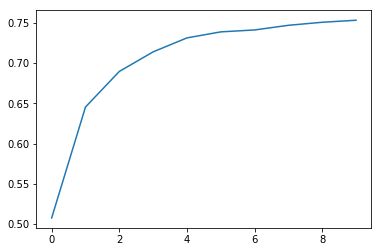

In [42]:
plt.plot([metrics.r2_score(y_valid, np.mean(preds[:i+1], axis=0)) for i in range(10)]);

The shape of this curve suggests that adding more trees isn't going to help us much (never going to get worse though). Let's check it! Compare this to our original model on a sample...

In [43]:
m = RandomForestRegressor(n_estimators=20, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.10049124597640009, 0.351085159410296, 0.9782039464394905, 0.7641851499132212]


In [44]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.09642166632651823, 0.3439062607803957, 0.9799335443529816, 0.7737303155881461]


In [45]:
m = RandomForestRegressor(n_estimators=80, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.09346653056837563, 0.3445168312270238, 0.9811446912255838, 0.7729261649411381]


This is the first parameter we have tried to tune. The usual is to work with 10 to 40 trees (time counts!) until optimization is required. Then you can try increasing that number, or... directly use grid search for hyper parameters optimization! :)

### Out-of-bag (OOB) score

Is our validation set worse than our training set because we're over-fitting? or because the validation set is for a different time period? or maybe a bit of both? With the existing information we've shown, we can't tell. However, random forests (bagging algorithms in general) have a very clever trick called *out-of-bag (OOB) error* which can handle this (and more!). In fact its main purpose is helping us with model evaluation when we have a very small dataset for train, and we don't want to use part of it for validation.

The idea is to evaluate each tree using the samples not chosen to train it; those would work as a validation set. To calculate the error in a sample we'll average the error of that sample for each tree where it was used for validation. This allows us to see whether the model is over-fitting.

Obtaining that is as simple as adding one more parameter to our model constructor. We print the OOB error last in our `print_score` function below.

In [46]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.09712196607256415, 0.3457429855650687, 0.9796410050240272, 0.7713069521065764, 0.8557422779600955]


This shows that our validation set time difference is making an impact, as is model over-fitting.

## Reducing over-fitting

### Subsampling

It turns out that one of the easiest ways to avoid over-fitting is also one of the best ways to speed up analysis: *subsampling*. Let's return to using our full dataset, so that we can demonstrate the impact of this technique.

In [47]:
df_trn, y_trn, nas = proc_df(df_raw, 'SalePrice')
X_train, X_valid = split_vals(df_trn, n_trn)
y_train, y_valid = split_vals(y_trn, n_trn)

The basic idea is this: rather than limit the total amount of data that our model can access, let's instead limit it to a *different* random subset per tree. That way, given enough trees, the model can still see *all* the data, but for each individual tree it'll be just as fast as if we had cut down our dataset as before. Bad news is that we lose the OoB score, but it's not a big problem!

In [48]:
set_rf_samples??

In [49]:
set_rf_samples(20000) # revert with reset_rf_samples()

In [50]:
m = RandomForestRegressor(n_jobs=-1, n_estimators=10, oob_score=False)
%time m.fit(X_train, y_train)
print_score(m)

Wall time: 2.69 s
[0.24028594872290698, 0.28602233303677277, 0.8796206149413056, 0.8434885567164063]


Since each additional tree allows the model to see more data, this approach can make additional trees more useful.

In [51]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1, oob_score=False)
m.fit(X_train, y_train)
print_score(m)

[0.22731233504925688, 0.26822534609684223, 0.8922688299625884, 0.8623596287203216]


This is a great option to work with large datasets instead of bagging.

### Tree building parameters

We revert to using a full bootstrap sample in order to show the impact of other over-fitting avoidance methods.

In [52]:
reset_rf_samples()

Let's get a baseline for this full set to compare to.

In [53]:
def dectree_max_depth(tree):
    children_left = tree.children_left
    children_right = tree.children_right

    def walk(node_id):
        if (children_left[node_id] != children_right[node_id]):
            left_max = 1 + walk(children_left[node_id])
            right_max = 1 + walk(children_right[node_id])
            return max(left_max, right_max)
        else: # leaf
            return 1

    root_node_id = 0
    return walk(root_node_id)

In [54]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.07830880974175196, 0.24477081308781407, 0.9872145324002498, 0.8853786635829745, 0.9087352853919877]


The reason why OoB is higher than R^2 is simply because OoB uses random samples for validation and R^2 uses the last ones of the time series; something more difficult to predict. 

We can get the depth for a tree:

In [55]:
t=m.estimators_[0].tree_

In [56]:
dectree_max_depth(t)

46

Another way to reduce over-fitting is to grow our trees less deeply. We do this by specifying (with `min_samples_leaf`) that we require some minimum number of rows in every leaf node. This has two benefits:

* There are less decision rules for each leaf node; simpler models should generalize better
* The predictions are made by averaging more rows in the leaf node, resulting in less volatility

Typical values: 1, 3, 5, 10, 25, 100

In [57]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.1408173170052391, 0.23932955006996712, 0.9586564751287985, 0.8904180926239238, 0.9070145701495556]


In [58]:
t=m.estimators_[0].tree_

In [59]:
dectree_max_depth(t)

38

In [60]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.11506678073000517, 0.24014439224396503, 0.972394520458231, 0.8896706382022547, 0.9083634677896762]


We can also increase the amount of variation amongst the trees by not only using a sample of rows for each tree, but by also using a sample of *columns* for each *split* (different columns in each one). We do this by specifying `max_features`, which is the proportion of features to randomly select from at each split. Remember: the less correlated trees we use, the better results we'll get.

Typical values: None, 1, 0.5, 'log2', 'sqrt'

In [61]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.11873243030305328, 0.2349832337285194, 0.9706076652738864, 0.8943620514241489, 0.9113212883751466]


We can't compare our results directly with the Kaggle competition, since it used a different validation set (and we can no longer to submit to this competition) - but we can at least see that we're getting similar results to the winners based on the dataset we have.

The sklearn docs [show an example](http://scikit-learn.org/stable/auto_examples/ensemble/plot_ensemble_oob.html) of different `max_features` methods with increasing numbers of trees - as you see, using a subset of features on each split requires using more trees, but results in better models:
![sklearn max_features chart](http://scikit-learn.org/stable/_images/sphx_glr_plot_ensemble_oob_001.png)

The reason why Random Forests performs so well is that decision trees are very flexible; they can split the samples over and over to model the dataset, so it adapts to pretty everything.

# Additional notes

We haven't used a test dataset in this notebook. In case we have one, we should execute the next code over that in order to be consistent with the operations made to the train dataset:

```
apply_cats(df_raw_test, df_raw)

X_test, _, _ = proc_df(df_raw_test, na_dict=nas)

y_pred = m.predict(X_test)
```

And we should execute the `add_datepart` function too.